In [1]:
import logging
import os
import sys
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import textalloc as ta
from seaborn._statistics import LetterValues
from tqdm import tqdm

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.load.LoadForClassification import RENAMER, LoadForClassification
from src.mcdm.GetRankingFromExperiments import GetRankingFromExperiments
from src.mcdm.ReadAlternatives import ReadAlternative
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams

os.chdir(PROJECT_DIR)
set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

CHECK: PathChecker = PathChecker()
STR: StandardNames = StandardNames()

FIG_DIR: Path = CHECK.check_directory(PROJECT_DIR / "reports" / "figures", exit=False)
FIG_DIR /= NOTEBOOK_PATH.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Figure directory is %s (exist: %s)", FIG_DIR, FIG_DIR.is_dir())

EXP_DIR:Path = CHECK.check_directory(PROJECT_DIR / "experiments", exit=False)

2025-01-01 16:48:37,225     INFO  MainProcess  MainThread Log start, project directory is /root/py_projects/aihiii (exist: True)
2025-01-01 16:48:37,226     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/reports/figures' exists
2025-01-01 16:48:37,227     INFO  MainProcess  MainThread Figure directory is /root/py_projects/aihiii/reports/figures/evaluate_lstm_treesearch (exist: True)
2025-01-01 16:48:37,229     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/experiments' exists


In [2]:
WIDTH: float = 448.13095 / 72 -0.2

In [3]:
ALTERNATIVES: pd.DataFrame = ReadAlternative(b_path=EXP_DIR, search_pattern="*_lstm_treesearch_*").get_data()
ALTERNATIVES

2025-01-01 16:48:47,793     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/experiments' exists
2025-01-01 16:48:47,797     INFO  MainProcess  MainThread Reading /root/py_projects/aihiii/experiments/2024-10-17-19-25-49_lstm_treesearch_use_sequence_output_false/results.json
2025-01-01 16:48:47,812     INFO  MainProcess  MainThread Reading /root/py_projects/aihiii/experiments/2024-11-15-21-50-52_lstm_treesearch_share_dense/results.json
2025-01-01 16:48:47,826     INFO  MainProcess  MainThread Reading /root/py_projects/aihiii/experiments/2024-10-15-10-12-02_lstm_treesearch_learning_rate/results.json
2025-01-01 16:48:47,836     INFO  MainProcess  MainThread Reading /root/py_projects/aihiii/experiments/2024-10-15-17-24-05_lstm_treesearch_learning_rate/results.json
2025-01-01 16:48:47,849     INFO  MainProcess  MainThread Reading /root/py_projects/aihiii/experiments/2024-11-30-19-54-14_lstm_treesearch_lstm_units/results.json
2025-01-01 16:48:47,878     INFO  MainProcess  Ma

Alternatives,2024-10-17-19-25-49_lstm_treesearch_use_sequence_output_false,2024-11-15-21-50-52_lstm_treesearch_share_dense,2024-10-15-10-12-02_lstm_treesearch_learning_rate,2024-10-15-17-24-05_lstm_treesearch_learning_rate,2024-11-30-19-54-14_lstm_treesearch_lstm_units,2024-10-07-15-09-34_lstm_treesearch_use_sequence_output,2024-11-14-15-09-57_lstm_treesearch_temporal_feature_n_tsps,2024-10-06-16-21-40_lstm_treesearch_ai_in,2024-10-11-13-54-55_lstm_treesearch_dense_layer_shapes,2024-10-08-06-11-44_lstm_treesearch_share_dense,...,2024-11-13-16-00-37_lstm_treesearch_ai_in,2024-10-09-14-06-11_lstm_treesearch_dense_layer_shapes,2024-10-16-08-19-25_lstm_treesearch_perc,2024-10-17-06-20-57_lstm_treesearch_use_sequence_output_false,2024-11-26-09-03-58_lstm_treesearch_lstm_units,2024-11-17-16-36-56_lstm_treesearch_share_lstm,2024-10-16-00-59-10_lstm_treesearch_perc,2024-11-14-21-35-18_lstm_treesearch_learning_rate,2024-10-13-04-31-24_lstm_treesearch_lstm_units,2024-10-12-04-21-14_lstm_treesearch_lstm_units
Criteria,,,,,,,,,,,,,,,,,,,,,
setup_db_num_sim_calibration_pprediction,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
setup_db_num_sim_calibration_sum,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,...,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03,8.192000e+03
setup_db_num_sim_crash,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
setup_db_comp_time_crash,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,...,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07
setup_db_num_sim_occupant,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,...,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04
setup_db_num_sim_training,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,...,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04,1.638500e+04
setup_db_num_sim_assessment,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
setup_training_num_sim_occupant,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,...,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04,1.638400e+04
setup_training_num_sim_crash,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [29]:
ALTERNATIVES.drop(columns=[c for c in ALTERNATIVES.columns if int(c.split("-")[1]) >= 11], inplace=True)

In [30]:
def get_factors():
    factors = {}
    for alternative in ALTERNATIVES.columns:
        f_path = EXP_DIR / alternative / STR.fname_para
        LOG.info("Reading factors from %s", f_path)
        paras = json_util.load(f_path)
        factors[alternative] = paras[STR.pipeline]
        for key in (
            "feature_extractor_path",
            "plot_model",
            "feature_extractor_path",
            "start_early_stopping_from_n_epochs",
            "max_epochs",
            "patience_factor",
        ):
            if key in factors[alternative]:
                del factors[alternative][key]
        factors[alternative][STR.perc] = paras[STR.perc][STR.target][0]
        factors[alternative]["ai_in"] = paras[STR.data][STR.input][STR.feature]

    factors = pd.DataFrame(factors).T
    factors.index.name = STR.alternatives
    factors.columns.name = "Factors"

    for col in factors.columns:
        if isinstance(factors[col].iloc[0], list):
            factors[col] = [tuple(q) for q in factors[col]]

    return factors


FACTORS:pd.DataFrame = get_factors()
FACTORS = FACTORS[FACTORS[STR.perc].eq(95)].copy()
ALTERNATIVES = ALTERNATIVES[FACTORS.index].copy()
FACTORS

2025-01-01 17:06:28,609     INFO  MainProcess  MainThread Reading factors from /root/py_projects/aihiii/experiments/2024-10-17-19-25-49_lstm_treesearch_use_sequence_output_false/parameters.json
2025-01-01 17:06:28,612     INFO  MainProcess  MainThread Reading factors from /root/py_projects/aihiii/experiments/2024-10-15-10-12-02_lstm_treesearch_learning_rate/parameters.json
2025-01-01 17:06:28,616     INFO  MainProcess  MainThread Reading factors from /root/py_projects/aihiii/experiments/2024-10-15-17-24-05_lstm_treesearch_learning_rate/parameters.json
2025-01-01 17:06:28,617     INFO  MainProcess  MainThread Reading factors from /root/py_projects/aihiii/experiments/2024-10-07-15-09-34_lstm_treesearch_use_sequence_output/parameters.json
2025-01-01 17:06:28,619     INFO  MainProcess  MainThread Reading factors from /root/py_projects/aihiii/experiments/2024-10-06-16-21-40_lstm_treesearch_ai_in/parameters.json
2025-01-01 17:06:28,620     INFO  MainProcess  MainThread Reading factors from /

Factors,dense_layer_shapes,temporal_feature_n_tsps,is_bidirectional,use_sequence_output,share_dense,learning_rate,dropout_rate,kernel_regularizer,lstm_units,baseline_threshold,PERC,ai_in
Alternatives,,,,,,,,,,,,
2024-10-17-19-25-49_lstm_treesearch_use_sequence_output_false,"(200, 50)",140,True,False,True,0.00001,0.2,l2,"(100,)",30,95,"(channels, injury_criteria)"
2024-10-15-10-12-02_lstm_treesearch_learning_rate,"(200, 50)",140,True,True,True,0.0001,0.2,l2,"(100,)",30,95,"(channels, injury_criteria)"
2024-10-15-17-24-05_lstm_treesearch_learning_rate,"(200, 50)",140,True,True,True,0.00001,0.2,l2,"(100,)",30,95,"(channels, injury_criteria)"
2024-10-07-15-09-34_lstm_treesearch_use_sequence_output,"(50, 20)",140,False,False,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
2024-10-06-16-21-40_lstm_treesearch_ai_in,"(50, 20)",140,False,False,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
2024-10-11-13-54-55_lstm_treesearch_dense_layer_shapes,"(200, 50)",140,True,True,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
2024-10-08-06-11-44_lstm_treesearch_share_dense,"(50, 20)",140,False,True,False,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
2024-10-12-18-39-57_lstm_treesearch_lstm_units,"(200, 50)",140,True,True,True,0.001,0.2,l2,"(300,)",30,95,"(channels, injury_criteria)"
2024-10-14-07-50-19_lstm_treesearch_lstm_units,"(200, 50)",140,True,True,True,0.001,0.2,l2,"(140, 280, 70)",30,95,"(channels, injury_criteria)"


In [31]:
def get_rankings() -> pd.DataFrame:
    r = GetRankingFromExperiments(b_path=EXP_DIR, files=FACTORS.index.to_list())
    r.get_data()
    return r.get_ranking()


RANKINGS: pd.DataFrame = get_rankings()
RANKINGS

2025-01-01 17:06:29,121     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/experiments' exists
2025-01-01 17:06:29,123     INFO  MainProcess  MainThread Read data from /root/py_projects/aihiii/experiments with search pattern ['2024-10-17-19-25-49_lstm_treesearch_use_sequence_output_false', '2024-10-15-10-12-02_lstm_treesearch_learning_rate', '2024-10-15-17-24-05_lstm_treesearch_learning_rate', '2024-10-07-15-09-34_lstm_treesearch_use_sequence_output', '2024-10-06-16-21-40_lstm_treesearch_ai_in', '2024-10-11-13-54-55_lstm_treesearch_dense_layer_shapes', '2024-10-08-06-11-44_lstm_treesearch_share_dense', '2024-10-12-18-39-57_lstm_treesearch_lstm_units', '2024-10-14-07-50-19_lstm_treesearch_lstm_units', '2024-10-07-07-14-15_lstm_treesearch_use_sequence_output', '2024-10-08-17-54-04_lstm_treesearch_is_bidirectional', '2024-10-10-15-36-38_lstm_treesearch_dense_layer_shapes', '2024-10-07-22-31-06_lstm_treesearch_share_dense', '2024-10-10-02-31-05_lstm_treesearch_dense_laye

,net_flow
Alternatives,
2024-10-13-04-31-24_lstm_treesearch_lstm_units,0.206250
2024-10-07-15-09-34_lstm_treesearch_use_sequence_output,0.134375
2024-10-06-16-21-40_lstm_treesearch_ai_in,0.112500
2024-10-07-22-31-06_lstm_treesearch_share_dense,0.106250
2024-10-06-23-47-50_lstm_treesearch_ai_in,0.084375
2024-10-09-06-20-13_lstm_treesearch_is_bidirectional,0.068750
2024-10-07-07-14-15_lstm_treesearch_use_sequence_output,0.056250
2024-10-12-18-39-57_lstm_treesearch_lstm_units,0.043750
2024-10-08-06-11-44_lstm_treesearch_share_dense,0.025000


2025-01-01 17:07:44,068     INFO  MainProcess  MainThread maxp pruned
2025-01-01 17:07:44,082     INFO  MainProcess  MainThread cmap pruned
2025-01-01 17:07:44,083     INFO  MainProcess  MainThread kern dropped
2025-01-01 17:07:44,084     INFO  MainProcess  MainThread post pruned
2025-01-01 17:07:44,085     INFO  MainProcess  MainThread FFTM dropped
2025-01-01 17:07:44,089     INFO  MainProcess  MainThread GPOS pruned
2025-01-01 17:07:44,096     INFO  MainProcess  MainThread GSUB pruned
2025-01-01 17:07:44,113     INFO  MainProcess  MainThread glyf pruned
2025-01-01 17:07:44,116     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-01 17:07:44,117     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-01 17:07:44,118     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 5 glyphs before
2025-01-01 17:07:44,118     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'Oslash', 'nonmarkingreturn', 'space']
2025-01-01 17:07:44,121     IN

{'us_MLmetric': Criteria                                            us_MLmetric  IDX
 Alternatives                                                        
 2024-10-06-16-21-40_lstm_treesearch_ai_in              0.910045    0
 2024-10-06-23-47-50_lstm_treesearch_ai_in              0.908653    1
 2024-10-07-07-14-15_lstm_treesearch_use_sequenc...     0.915295    2
 2024-10-07-15-09-34_lstm_treesearch_use_sequenc...     0.909599    3
 2024-10-07-22-31-06_lstm_treesearch_share_dense        0.915055    4
 2024-10-08-06-11-44_lstm_treesearch_share_dense        0.912723    5
 2024-10-08-17-54-04_lstm_treesearch_is_bidirect...     0.916578    6
 2024-10-09-06-20-13_lstm_treesearch_is_bidirect...     0.915772    7
 2024-10-09-14-06-11_lstm_treesearch_dense_layer...     0.916211    8
 2024-10-10-02-31-05_lstm_treesearch_dense_layer...     0.915411    9
 2024-10-10-15-36-38_lstm_treesearch_dense_layer...     0.916062   10
 2024-10-11-13-54-55_lstm_treesearch_dense_layer...     0.916234   11
 2024

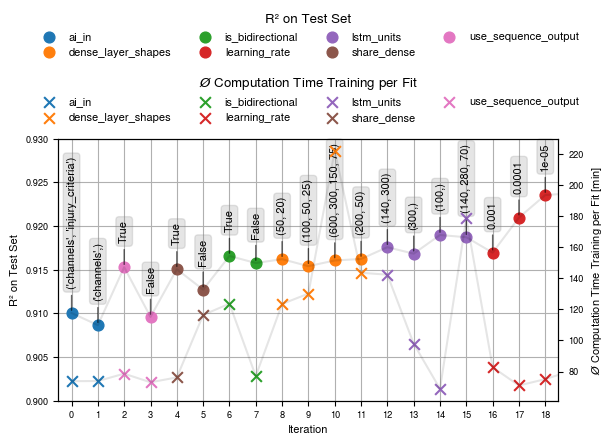

In [37]:
def make_a_plot():
    groups = set([x[36:] for x in sorted(ALTERNATIVES.columns) if not x.endswith("false")])
    groups = set([x for x in groups if "perc" not in x])
    fig, (axl1, axl2, ax1) = plt.subplots(
        nrows=3,
        height_ratios=[0.1, 0.1, 1],
        layout="constrained",
    )
    ax2 = ax1.twinx()
    criteria = ("us_MLmetric", "setup_training_comp_time_metamodel")
    naming = {
        "us_MLmetric": "R² on Test Set",
        "setup_training_comp_time_metamodel": "$\O$ Computation Time Training per Fit [min]",
    }

    j = 0
    stored = {}
    for criterion, ax in zip(criteria, (ax1, ax2)):
        data = ALTERNATIVES.loc[[criterion]].T.sort_index()
        data["IDX"] = range(data.shape[0])
        stored[criterion] = data

        if criterion == criteria[0]:
            data[criterion] -= 1
            data[criterion] *= -1
        else:
            data[criterion] /= 60
            data[criterion] /= 6

        ax.plot(data["IDX"], data[criterion], c="black", alpha=0.1)

        for group in sorted(groups):
            idx = [x for x in data.index if x[36:] in group]

            ax.scatter(
                data.loc[idx, "IDX"],
                data.loc[idx, criterion],
                label=group,
                s=60,
                marker="o" if criterion == criteria[0] else "x",
            )

            if criterion == criteria[0]:
                for i in idx:
                    try:
                        ax.annotate(
                            text=FACTORS.loc[i, group],
                            xy=(data.loc[i, "IDX"], data.loc[i, criterion]),
                            xytext=(data.loc[i, "IDX"], 0.003 + data.loc[i, criterion]),  # 0.915 + j * 0.0008),
                            arrowprops=dict(ec="black", lw=1, arrowstyle="-", alpha=0.6),
                            ha="center",
                            bbox=dict(boxstyle="round", fc="grey", ec="grey", alpha=0.2),
                            rotation=90,
                        )
                        j += 1
                    except KeyError:
                        pass

        ax.set_ylabel(naming[criterion])

    axl1.legend(*ax1.get_legend_handles_labels(), loc="center", ncol=4, title=naming[criteria[0]])
    axl1.axis("off")
    axl2.legend(*ax2.get_legend_handles_labels(), loc="center", ncol=4, title=" ".join(naming[criteria[1]].split()[:-1]))
    axl2.axis("off")

    ax1.grid()
    ax1.set_xticks(range(data.shape[0] - 2))
    ax1.set_axisbelow(True)
    ax1.set_xlim([-0.5, 18.5])
    ax1.set_xlabel("Iteration")
    ax1.set_ylim([0.9, 0.93])
    # ax2.set_ylim([0, 82000])

    fig.set_figwidth(WIDTH)
    fig.set_figheight(WIDTH * 0.72)
    fig.savefig(FIG_DIR / "lstm_tournament.pdf")

    return stored


STORED = make_a_plot()
STORED

In [7]:
def get_duplicates(criterion: str = "us_MLmetric"):
    c = list(FACTORS.columns)
    c = FACTORS.reset_index().set_index(c).sort_index()
    w = []

    grouper = {}
    used = set()
    for qq, idx in enumerate(c.index):
        if idx in used:
            continue
        used.add(idx)
        n = c.loc[idx]
        if n.shape[0] > 1:
            for i in range(n.shape[0]):
                w.append(
                    (
                        ALTERNATIVES.loc[criterion, n.iloc[i]].to_list()[0],
                        str(i),
                        str(qq),
                        STORED[criterion].loc[n.iloc[i]["Alternatives"], "IDX"],
                    )
                )
            grouper[qq] = idx

    w = pd.DataFrame(w, columns=[criterion, "Repetition", "Group", "IDX"])
    w[criterion] -= 1
    w[criterion] *= -1
    grouper = pd.DataFrame(grouper, index=c.index.names).T

    display(grouper)

    fig, ax = plt.subplots(figsize=(WIDTH, 0.3 * WIDTH))
    plots = sns.barplot(
        w,
        y=criterion,
        x="Group",
        hue="Repetition",
        legend=False,
        ax=ax,
        gap=0.1,
    )
    ax.set_ylim([0.9, 0.93])
    ax.set_ylabel("R² on Test Set")
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.grid()
    ax.set_axisbelow(True)

    q = w.set_index(criterion)
    for bar in plots.patches:
        plots.annotate(
            q.loc[bar.get_height(), "IDX"],
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="center",
            xytext=(0, 8),
            textcoords="offset points",
        )

    fig.savefig(FIG_DIR / f"lstm_tournament_duplicates_{criterion}.pdf")


get_duplicates()

TypeError: unhashable type: 'list'

,dense_layer_shapes,temporal_feature_n_tsps,is_bidirectional,use_sequence_output,share_dense,learning_rate,dropout_rate,kernel_regularizer,lstm_units,baseline_threshold,PERC,ai_in
1,"(50, 20)",140,False,False,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
4,"(50, 20)",140,False,True,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
7,"(50, 20)",140,True,True,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"
11,"(200, 50)",140,True,True,True,0.00001,0.2,l2,"(100,)",30,95,"(channels, injury_criteria)"
14,"(200, 50)",140,True,True,True,0.001,0.2,l2,"(100,)",30,95,"(channels, injury_criteria)"
17,"(200, 50)",140,True,True,True,0.001,0.2,l2,"(140, 300)",30,95,"(channels, injury_criteria)"


,setup_training_comp_time_metamodel,Repetition,Group,IDX
0,-26295.622445,0,1,3
1,-26559.323098,1,1,0
2,-28299.327594,0,4,2
3,-27438.257545,1,4,4
4,-27739.208059,2,4,7
5,-44535.434330,0,7,6
6,-44457.243717,1,7,8
7,-27030.784107,0,11,18
8,-28988.558149,1,11,19
9,-29787.528593,0,14,16


2024-11-04 09:04:08,281     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-04 09:04:08,300     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-04 09:04:08,614     INFO  MainProcess  MainThread maxp pruned
2024-11-04 09:04:08,620     INFO  MainProcess  MainThread cmap pruned
2024-11-04 09:04:08,621     INFO  MainProcess  MainThread post pruned
2024-11-04 09:04:08,623     INFO  MainProcess  MainThread CFF  pruned
2024-11-04 09:04:08,627     INFO  MainProcess  MainThread GPOS pruned
2024-11-04 09:04:08,644     INFO  MainProcess  MainThread GSUB pruned
2024-11-04 09:04:08,645     INFO  MainProcess  MainThread Added .notdef to subset
20

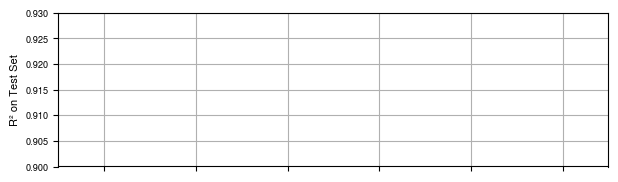

In [275]:
get_duplicates("setup_training_comp_time_metamodel")